In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

/is/sg/klee/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### graph visualization utility

In [2]:
# TensorFlow Graph visualizer code
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Constructing The Concrete Distribution

#### uniform random variable generation

In [38]:
u = tf.random_uniform(shape=[1], dtype=tf.float32)
u.eval(session=tf.Session())

array([0.73155], dtype=float32)

#### getting intitial $\alpha$, $\gamma$, $\beta$, $\ksi$

In [254]:
tf.reset_default_graph()

gamma = tf.constant(-0.1)
ksi = tf.constant(1.1)
beta = tf.constant(2/3)

# Louizos(18) m_a/(1+m_a) == 0.3, pitfall: may still lead to negative values
alpha = tf.Variable(tf.random_normal([1], mean=3/7, stddev=1e-3)) 
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    print(sess.run(alpha))

[0.4281492]


In [146]:
# test how small can tf.log tolerate
eps = 1e-7
log_eps = tf.log(eps)
print(log_eps.eval(session=tf.Session()))

-16.118095


#### construct hard sigmoid transformation in tf

In [ ]:
def tf_hard_sigmoid(u):
    h = tf.minimum(1.0, tf.maximum(0.0,u))
    return h

In [290]:
tf.reset_default_graph()
u = tf.placeholder(shape=[None,1], dtype=tf.float32)

In [292]:
test_1 = tf_hard_sigmoid(u)

In [305]:
# for sanity check (-inf,0): 0, (0,1): identitiy, (1, inf): 1
inin = [-10, -5, 0, 0.1, 0.3, 0.5, 0.8, 1, 5, 10] 
inin = np.array(inin)[np.newaxis]
inin = inin.transpose() # make proper data shape

test_1_out = test_1.eval(session=tf.Session(), feed_dict = {u: inin})
print(test_1_out)

[[0. ]
 [0. ]
 [0. ]
 [0.1]
 [0.3]
 [0.5]
 [0.8]
 [1. ]
 [1. ]
 [1. ]]


In [308]:
# test the gradient w.r.t tf_hard_sigmoid
dh = tf.gradients(test_1, u)
dh_out = dh[0].eval(session=tf.Session(), feed_dict = {u: inin})
print(dh_out)

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]]


#### Concrete Random Variable

In [3]:
def tf_concrete_transoform(u, alpha, beta=2/3):
    ct = tf.nn.sigmoid((tf.log(u) - tf.log(1-u) + tf.log(alpha))/beta)
    return ct

In [4]:
def tf_stretch(s, interval):
    """
    interval: [a,b], the lower/upper bound of the interval to stretch up
    """
    s_bar = s * (interval[1]-interval[0]) + interval[0]
    return s_bar

In [8]:
interval = [-0.1, 1.1]
n_sparse = 10
beta = 2/3
tf.reset_default_graph()

g = tf.Graph()
with g.as_default():
    u = tf.random_uniform(shape=[n_sparse], dtype=tf.float32, name='')
    alpha = tf.Variable(tf.random_normal([n_sparse], mean=3/7, stddev=1e-3)) # the parameter to tune
    s = tf_concrete_transoform(u, alpha) 
    s_bar = tf_stretch(s, interval)
    z = tf_hard_sigmoid(s_bar)
    regs = tf.nn.sigmoid(tf.log(alpha) - beta * (tf.log(-interval[0])-tf.log(interval[1]) ))
    reg = tf.reduce_sum(regs)

init = tf.global_variables_initializer()

In [9]:
show_graph(g)

In [425]:
with tf.Session() as sess:
    sess.run(init)
    z_out = z.eval(session=sess)
    alpha_out = alpha.eval(session=sess)
    regs_out = regs.eval(session=sess)
    reg_out = reg.eval(session=sess)
    #print(z_out)
    print(alpha_out)
    print(regs_out)
    print(reg_out)

[0.42667225 0.4289318  0.42948735 0.429014   0.42848217 0.42918637
 0.42895344 0.42715484 0.42912388 0.42867666]
[0.6784937  0.6796447  0.6799265  0.6796864  0.6794163  0.67977387
 0.67965573 0.67874014 0.6797422  0.6795152 ]
6.794595


(array([6., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]),
 array([0.        , 0.04392972, 0.08785945, 0.13178917, 0.1757189 ,
        0.21964862, 0.26357834, 0.30750807, 0.35143779, 0.39536752,
        0.43929724, 0.48322696, 0.52715669, 0.57108641, 0.61501613,
        0.65894586]),
 <a list of 15 Patch objects>)

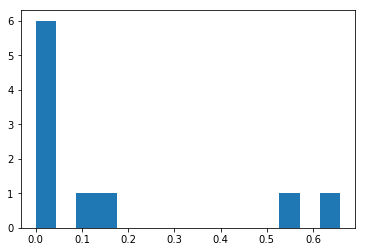

In [412]:
# concrete r.v. generation
plt.hist(z_out, bins=15)

# Experiment: $L_0$ Sparse MLP

In [ ]:
dim_h = [5,5]
dim_z = 10 

# the input x